# Introduction to PyTorch

- [Learn the Basics](https://pytorch.org/tutorials/beginner/basics/intro.html)


## Quickstart

https://pytorch.org/tutorials/beginner/basics/quickstart_tutorial.html


In [1]:
from pathlib import Path
import torch
from torch import nn
from torch.utils.data import DataLoader, Dataset
from torchvision import datasets, transforms
from torchvision.transforms import ToTensor, Lambda
from torchvision.io import read_image
import torchvision.models as models
import matplotlib.pyplot as plt
import os
import pandas as pd

DATA_DIR = Path.home() / "data"

In [2]:
# Download training data from open datasets.
training_data = datasets.FashionMNIST(
  root=DATA_DIR,
  train=True,
  download=True,
  transform=ToTensor(),
)

# Download test data from open datasets.
test_data = datasets.FashionMNIST(
  root=DATA_DIR,
  train=False,
  download=True,
  transform=ToTensor(),
)

In [3]:
batch_size = 64

# Create data loaders.
train_dataloader = DataLoader(training_data, batch_size=batch_size)
test_dataloader = DataLoader(test_data, batch_size=batch_size)

for X, y in test_dataloader:
  print(f"Shape of X [N, C, H, W]: {X.shape}")
  print(f"Shape of y: {y.shape} {y.dtype}")
  break

Shape of X [N, C, H, W]: torch.Size([64, 1, 28, 28])
Shape of y: torch.Size([64]) torch.int64


In [4]:
# Get cpu, gpu or mps device for training.
device = (
  "cuda" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu"
)
print(f"Using {device} device")


# Define model
class NeuralNetwork(nn.Module):
  def __init__(self):
    super().__init__()
    self.flatten = nn.Flatten()
    self.linear_relu_stack = nn.Sequential(
      nn.Linear(28 * 28, 512), nn.ReLU(), nn.Linear(512, 512), nn.ReLU(), nn.Linear(512, 10)
    )

  def forward(self, x):
    x = self.flatten(x)
    logits = self.linear_relu_stack(x)
    return logits


model = NeuralNetwork().to(device)
print(model)

Using mps device
NeuralNetwork(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=784, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=512, bias=True)
    (3): ReLU()
    (4): Linear(in_features=512, out_features=10, bias=True)
  )
)


In [5]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=1e-3)

In [6]:
def train(dataloader, model, loss_fn, optimizer):
  size = len(dataloader.dataset)
  model.train()
  for batch, (X, y) in enumerate(dataloader):
    X, y = X.to(device), y.to(device)

    # Compute prediction error
    pred = model(X)
    loss = loss_fn(pred, y)

    # Backpropagation
    loss.backward()
    optimizer.step()
    optimizer.zero_grad()

    if batch % 100 == 0:
      loss, current = loss.item(), (batch + 1) * len(X)
      print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")

In [7]:
def test(dataloader, model, loss_fn):
  size = len(dataloader.dataset)
  num_batches = len(dataloader)
  model.eval()
  test_loss, correct = 0, 0
  with torch.no_grad():
    for X, y in dataloader:
      X, y = X.to(device), y.to(device)
      pred = model(X)
      test_loss += loss_fn(pred, y).item()
      correct += (pred.argmax(1) == y).type(torch.float).sum().item()
  test_loss /= num_batches
  correct /= size
  print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")

In [8]:
epochs = 5
for t in range(epochs):
  print(f"Epoch {t+1}\n-------------------------------")
  train(train_dataloader, model, loss_fn, optimizer)
  test(test_dataloader, model, loss_fn)
print("Done!")

Epoch 1
-------------------------------
loss: 2.302699  [   64/60000]
loss: 2.282561  [ 6464/60000]
loss: 2.278250  [12864/60000]
loss: 2.268418  [19264/60000]
loss: 2.238297  [25664/60000]
loss: 2.232692  [32064/60000]
loss: 2.229742  [38464/60000]
loss: 2.201360  [44864/60000]
loss: 2.182444  [51264/60000]
loss: 2.163365  [57664/60000]
Test Error: 
 Accuracy: 45.3%, Avg loss: 2.154968 

Epoch 2
-------------------------------
loss: 2.161929  [   64/60000]
loss: 2.141334  [ 6464/60000]
loss: 2.100504  [12864/60000]
loss: 2.109572  [19264/60000]
loss: 2.055849  [25664/60000]
loss: 2.015914  [32064/60000]
loss: 2.033855  [38464/60000]
loss: 1.963130  [44864/60000]
loss: 1.951654  [51264/60000]
loss: 1.892297  [57664/60000]
Test Error: 
 Accuracy: 58.8%, Avg loss: 1.888580 

Epoch 3
-------------------------------
loss: 1.919180  [   64/60000]
loss: 1.875467  [ 6464/60000]
loss: 1.778640  [12864/60000]
loss: 1.810668  [19264/60000]
loss: 1.701991  [25664/60000]
loss: 1.667272  [32064/600

In [9]:
torch.save(model.state_dict(), "model.pth")
print("Saved PyTorch Model State to model.pth")


Saved PyTorch Model State to model.pth


In [10]:
model = NeuralNetwork().to(device)
model.load_state_dict(torch.load("model.pth", weights_only=True))

<All keys matched successfully>

In [11]:
classes = [
  "T-shirt/top",
  "Trouser",
  "Pullover",
  "Dress",
  "Coat",
  "Sandal",
  "Shirt",
  "Sneaker",
  "Bag",
  "Ankle boot",
]

model.eval()
x, y = test_data[0][0], test_data[0][1]
with torch.no_grad():
  x = x.to(device)
  pred = model(x)
  predicted, actual = classes[pred[0].argmax(0)], classes[y]
  print(f'Predicted: "{predicted}", Actual: "{actual}"')

Predicted: "Ankle boot", Actual: "Ankle boot"


## Datasets & DataLoaders

https://pytorch.org/tutorials/beginner/basics/data_tutorial.html


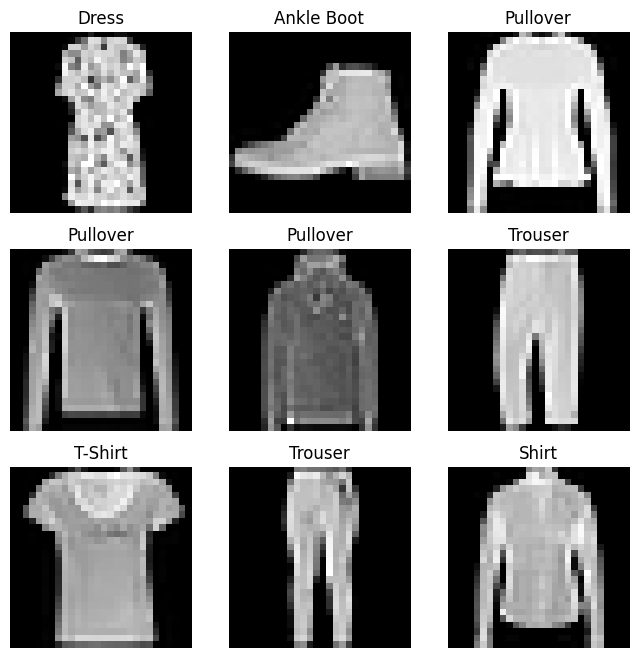

In [12]:
labels_map = {
  0: "T-Shirt",
  1: "Trouser",
  2: "Pullover",
  3: "Dress",
  4: "Coat",
  5: "Sandal",
  6: "Shirt",
  7: "Sneaker",
  8: "Bag",
  9: "Ankle Boot",
}
figure = plt.figure(figsize=(8, 8))
cols, rows = 3, 3
for i in range(1, cols * rows + 1):
  sample_idx = torch.randint(len(training_data), size=(1,)).item()
  img, label = training_data[sample_idx]
  figure.add_subplot(rows, cols, i)
  plt.title(labels_map[label])
  plt.axis("off")
  plt.imshow(img.squeeze(), cmap="gray")
plt.show()

### Creating a Custom Dataset for your files


In [13]:
class CustomImageDataset(Dataset):
  """
  自定义图像数据集类，继承自torch.utils.data.Dataset。
  用于加载带有注释文件的图像数据集，支持对图像和标签的转换操作。

  参数:
  - annotations_file: str, 注释文件的路径，注释文件中包含了图像文件名和对应的标签信息。
  - img_dir: str, 存放图像文件的目录路径。
  - transform: Callable, 可选，对图像进行转换的操作，例如裁剪、翻转等。
  - target_transform: Callable, 可选，对标签进行转换的操作。
  """

  def __init__(self, annotations_file, img_dir, transform=None, target_transform=None):
    # 读取注释文件，注释文件是包含图像名称和标签的CSV文件
    self.img_labels = pd.read_csv(annotations_file)
    # 存储图像文件的目录路径
    self.img_dir = img_dir
    # 对图像进行转换的操作
    self.transform = transform
    # 对标签进行转换的操作
    self.target_transform = target_transform

  def __len__(self):
    """返回数据集中图像的数量。"""
    return len(self.img_labels)

  def __getitem__(self, idx):
    """
    根据索引idx获取并返回一个图像样本及其对应的标签。

    参数:
    - idx: int, 图像样本的索引。

    返回:
    - Tuple, 包含图像样本和其对应的标签。
    """
    # 构造图像的完整路径
    img_path = os.path.join(self.img_dir, self.img_labels.iloc[idx, 0])
    image = read_image(img_path)
    # 获取对应的标签
    label = self.img_labels.iloc[idx, 1]
    # 如果提供了图像转换操作，则对图像进行转换
    if self.transform:
      image = self.transform(image)
    # 如果提供了标签转换操作，则对标签进行转换
    if self.target_transform:
      label = self.target_transform(label)
    # 返回图像样本和标签，读取的 CSV 文件类似如下：
    # tshirt1.jpg, 0
    # tshirt2.jpg, 0
    # ......
    # ankleboot999.jpg, 9
    return image, label

In [14]:
# 准备训练数据

train_dataloader = DataLoader(training_data, batch_size=64, shuffle=True)
test_dataloader = DataLoader(test_data, batch_size=64, shuffle=True)

Feature batch shape: torch.Size([64, 1, 28, 28])
Labels batch shape: torch.Size([64])


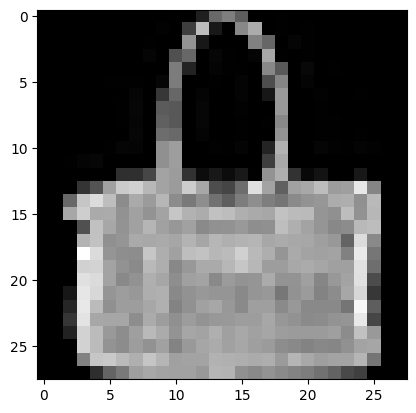

Label: 8


In [15]:
# Display image and label.
train_features, train_labels = next(iter(train_dataloader))
print(f"Feature batch shape: {train_features.size()}")
print(f"Labels batch shape: {train_labels.size()}")
# 提取第一个图像并去除多余的维度
img = train_features[0].squeeze()
label = train_labels[0]
plt.imshow(img, cmap="gray")
plt.show()
print(f"Label: {label}")

## Transforms

https://pytorch.org/tutorials/beginner/basics/transforms_tutorial.html


In [16]:
ds = datasets.FashionMNIST(
  root=DATA_DIR,
  train=True,
  download=True,
  # ToTensor 将 PIL 图像或 NumPy ndarray 转换为 FloatTensor 。并将图像的像素强度值缩放到 [0., 1.] 的范围内。
  transform=ToTensor(),
  # Lambda 转换应用任何用户定义的 lambda 函数。在这里，我们定义一个函数将整数转换为独热编码张量。
  # 它首先创建一个大小为 10 的零张量（我们数据集中标签的数量），并调用 scatter_，
  # 该函数在由标签 y 给定的索引上分配一个 value=1 。
  target_transform=Lambda(
    lambda y: torch.zeros(10, dtype=torch.float).scatter_(0, torch.tensor(y), value=1)
  ),
)
ds

Dataset FashionMNIST
    Number of datapoints: 60000
    Root location: /Users/yangjing/data
    Split: Train
    StandardTransform
Transform: ToTensor()
Target transform: Lambda()

## Build the Neural Network

https://pytorch.org/tutorials/beginner/basics/buildmodel_tutorial.html


In [17]:
# 定义神经网络类
class NeuralNetwork(nn.Module):
  def __init__(self):
    super().__init__()
    self.flatten = nn.Flatten()
    self.linear_relu_stack = nn.Sequential(
      nn.Linear(28 * 28, 512),
      nn.ReLU(),
      nn.Linear(512, 512),
      nn.ReLU(),
      nn.Linear(512, 10),
    )

  def forward(self, x):
    x = self.flatten(x)
    logits = self.linear_relu_stack(x)
    return logits

In [18]:
model = NeuralNetwork().to(device)
print(model)

NeuralNetwork(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=784, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=512, bias=True)
    (3): ReLU()
    (4): Linear(in_features=512, out_features=10, bias=True)
  )
)


In [19]:
X = torch.rand(1, 28, 28, device=device)
# 要使用模型，我们将输入数据传递给它。这会执行模型的 forward ，以及一些后台操作。不要直接调用 model.forward() ！
logits = model(X)
# 在输入上调用模型返回一个二维张量，dim=0 对应于每个类别的 10 个原始预测值的输出，dim=1 对应于每个输出的单个值。
# 我们通过将其传递给 nn.Softmax 模块的一个实例来获得预测概率。
pred_probab = nn.Softmax(dim=1)(logits)
y_pred = pred_probab.argmax(1)
print(f"Predicted class: {y_pred}")

Predicted class: tensor([7], device='mps:0')


### Model Layers


In [20]:
input_image = torch.rand(3, 28, 28)
print(input_image.size())

torch.Size([3, 28, 28])


In [21]:
# 我们初始化 nn.Flatten 层，将每个 2D 28x28 图像转换为一个连续的 784 像素值数组（保持小批量维度（在 dim=0））。
flatten = nn.Flatten()
flat_image = flatten(input_image)
print(flat_image.size())

torch.Size([3, 784])


In [22]:
# 线性层是一个模块，它使用存储的权重和偏置对输入应用线性变换。
layer1 = nn.Linear(in_features=28 * 28, out_features=20)
hidden1 = layer1(flat_image)
print(hidden1.size())

torch.Size([3, 20])


In [23]:
# 非线性激活是创建模型输入和输出之间复杂映射的原因。它们在线性变换之后应用，以引入非线性，帮助神经网络学习各种现象。
print(f"Before ReLU: {hidden1}\n\n")
hidden1 = nn.ReLU()(hidden1)
print(f"After ReLU: {hidden1}")


Before ReLU: tensor([[ 1.1925e-01,  4.7486e-01,  1.2103e-03,  3.1872e-02,  2.1483e-02,
         -4.7218e-02, -4.6316e-01, -3.5146e-01, -5.4564e-01,  3.0408e-01,
         -1.5337e-01,  1.4589e-01, -3.2466e-01,  9.2100e-01,  1.4451e-01,
         -1.7631e-01, -1.0649e-01, -3.8257e-01,  3.4162e-01, -1.8739e-01],
        [ 8.6719e-04,  8.3002e-02, -9.9642e-02,  1.8860e-01,  3.3531e-01,
         -6.3137e-03, -3.7019e-01, -1.0455e-02, -8.6134e-03,  4.1513e-01,
          8.2136e-02, -7.0921e-02, -3.1451e-01,  8.4875e-01,  7.9693e-02,
         -1.6903e-01, -4.1167e-01, -8.2619e-02,  2.8751e-01, -9.2631e-02],
        [ 4.0538e-01,  4.4696e-02, -1.1650e-01, -7.3744e-02,  2.2753e-01,
         -4.1422e-02, -8.9453e-02,  1.4115e-02, -1.5648e-01,  3.7108e-01,
         -1.1247e-02, -1.4739e-01, -2.1514e-01,  9.3629e-01,  1.4309e-01,
         -1.1902e-01, -1.9782e-01, -4.3189e-01,  1.5192e-01, -1.9981e-02]],
       grad_fn=<AddmmBackward0>)


After ReLU: tensor([[1.1925e-01, 4.7486e-01, 1.2103e-03, 3.1

In [24]:
# nn.Sequential 是一个有序的模块容器。数据按照定义的顺序通过所有模块。
# 您可以使用顺序容器快速组建一个网络，如 seq_modules 。
seq_modules = nn.Sequential(flatten, layer1, nn.ReLU(), nn.Linear(20, 10))
input_image = torch.rand(3, 28, 28)
logits = seq_modules(input_image)


In [25]:
# 神经网络的最后一层线性层返回 logits - 在[-infty, infty]中的原始值 - 这些值被传递到 nn.Softmax 模块。
# logits 被缩放到[0, 1]的值，表示模型对每个类别的预测概率。 dim 参数指示值必须沿着哪个维度求和为 1。
softmax = nn.Softmax(dim=1)
pred_probab = softmax(logits)


### Model Parameters


In [26]:
print(f"Model structure: {model}\n\n")

for name, param in model.named_parameters():
  print(f"Layer: {name} | Size: {param.size()} | Values : {param[:2]} \n")

Model structure: NeuralNetwork(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=784, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=512, bias=True)
    (3): ReLU()
    (4): Linear(in_features=512, out_features=10, bias=True)
  )
)


Layer: linear_relu_stack.0.weight | Size: torch.Size([512, 784]) | Values : tensor([[-0.0310, -0.0017,  0.0224,  ...,  0.0210, -0.0258,  0.0189],
        [-0.0140, -0.0282, -0.0124,  ...,  0.0272, -0.0001, -0.0180]],
       device='mps:0', grad_fn=<SliceBackward0>) 

Layer: linear_relu_stack.0.bias | Size: torch.Size([512]) | Values : tensor([-0.0263, -0.0157], device='mps:0', grad_fn=<SliceBackward0>) 

Layer: linear_relu_stack.2.weight | Size: torch.Size([512, 512]) | Values : tensor([[ 0.0364,  0.0128, -0.0437,  ..., -0.0402,  0.0137, -0.0024],
        [-0.0248, -0.0410, -0.0374,  ...,  0.0093,  0.0293, -0.0150]],
       device='mps:0', grad_fn=<Slice

## Automatic Differentiation with `torch.autograd`


In [27]:
import torch

x = torch.ones(5)  # input tensor
y = torch.zeros(3)  # expected output
w = torch.randn(5, 3, requires_grad=True)
b = torch.randn(3, requires_grad=True)
z = torch.matmul(x, w) + b
loss = torch.nn.functional.binary_cross_entropy_with_logits(z, y)

此代码定义了以下计算图：
![image.png](https://pytorch.org/tutorials/_images/comp-graph.png)


In [28]:
print(f"Gradient function for z = {z.grad_fn}")
print(f"Gradient function for loss = {loss.grad_fn}")

Gradient function for z = <AddBackward0 object at 0x328103f70>
Gradient function for loss = <BinaryCrossEntropyWithLogitsBackward0 object at 0x328103f70>


In [29]:
# 计算梯度
loss.backward()
print(w.grad)
print(b.grad)

tensor([[0.1926, 0.1461, 0.3292],
        [0.1926, 0.1461, 0.3292],
        [0.1926, 0.1461, 0.3292],
        [0.1926, 0.1461, 0.3292],
        [0.1926, 0.1461, 0.3292]])
tensor([0.1926, 0.1461, 0.3292])


In [30]:
# 禁用梯度追踪
z = torch.matmul(x, w) + b
print(z.requires_grad)

# 默认情况下，所有具有 requires_grad=True 的张量都在跟踪其计算历史并支持梯度计算。
# 然而，在某些情况下，我们不需要这样做，例如，当我们已经训练好模型并只想将其应用于一些输入数据时，
# 即我们只想通过网络进行前向计算。我们可以通过将计算代码包围在 torch.no_grad() 块中来停止跟踪计算：
with torch.no_grad():
  z = torch.matmul(x, w) + b
print(z.requires_grad)

True
False


In [31]:
# 另一种实现相同结果的方法是对张量使用 detach() 方法：
z = torch.matmul(x, w) + b
z_det = z.detach()
print(z_det.requires_grad)

False


In [32]:
# 张量梯度和雅可比乘积
inp = torch.eye(4, 5, requires_grad=True)
out = (inp + 1).pow(2).t()
out.backward(torch.ones_like(out), retain_graph=True)
print(f"First call\n{inp.grad}")
out.backward(torch.ones_like(out), retain_graph=True)
print(f"\nSecond call\n{inp.grad}")
inp.grad.zero_()
out.backward(torch.ones_like(out), retain_graph=True)
print(f"\nCall after zeroing gradients\n{inp.grad}")

First call
tensor([[4., 2., 2., 2., 2.],
        [2., 4., 2., 2., 2.],
        [2., 2., 4., 2., 2.],
        [2., 2., 2., 4., 2.]])

Second call
tensor([[8., 4., 4., 4., 4.],
        [4., 8., 4., 4., 4.],
        [4., 4., 8., 4., 4.],
        [4., 4., 4., 8., 4.]])

Call after zeroing gradients
tensor([[4., 2., 2., 2., 2.],
        [2., 4., 2., 2., 2.],
        [2., 2., 4., 2., 2.],
        [2., 2., 2., 4., 2.]])


## Optimizing Model Parameters

https://pytorch.org/tutorials/beginner/basics/optimization_tutorial.html


In [33]:
training_data = datasets.FashionMNIST(
  root=DATA_DIR, train=True, download=True, transform=ToTensor()
)
test_data = datasets.FashionMNIST(root=DATA_DIR, train=False, download=True, transform=ToTensor())

train_dataloader = DataLoader(training_data, batch_size=64)
test_dataloader = DataLoader(test_data, batch_size=64)


class NeuralNetwork(nn.Module):
  def __init__(self):
    super().__init__()
    self.flatten = nn.Flatten()
    self.linear_relu_stack = nn.Sequential(
      nn.Linear(28 * 28, 512),
      nn.ReLU(),
      nn.Linear(512, 512),
      nn.ReLU(),
      nn.Linear(512, 10),
    )

  def forward(self, x):
    x = self.flatten(x)
    logits = self.linear_relu_stack(x)
    return logits


model = NeuralNetwork()
model

NeuralNetwork(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=784, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=512, bias=True)
    (3): ReLU()
    (4): Linear(in_features=512, out_features=10, bias=True)
  )
)

### Hyperparameters


In [34]:
# 每个批次/周期更新模型参数的幅度。较小的值会导致学习速度缓慢，而较大的值可能会在训练过程中导致不可预测的行为
learning_rate = 1e-3
# 在更新参数之前，通过网络传播的数据样本数量
batch_size = 64
# 对数据集迭代的次数
epochs = 5


### Optimization Loop

一旦我们设置了超参数，就可以通过优化循环训练和优化我们的模型。优化循环的每次迭代称为一个周期。

每个时代由两个主要部分组成：

- 训练循环 - 遍历训练数据集并尝试收敛到最佳参数。
- 验证/测试循环 - 遍历测试数据集以检查模型性能是否在改善。

#### Loss Function

当提供一些训练数据时，我们未训练的网络可能无法给出正确的答案。损失函数衡量获得结果与目标值之间的不相似程度，而我们希望在训练过程中最小化的正是损失函数。为了计算损失，我们使用给定数据样本的输入进行预测，并将其与真实数据标签值进行比较。

常见的损失函数包括 `nn.MSELoss`（均方误差）用于回归任务，以及 `nn.NLLLoss`（负对数似然）用于分类。`nn.CrossEntropyLoss` 结合了 `nn.LogSoftmax` 和 `nn.NLLLoss` 。

#### Optimizer

优化是调整模型参数以减少每个训练步骤中模型误差的过程。优化算法定义了如何执行这个过程（在这个例子中我们使用随机梯度下降）。所有优化逻辑都封装在 `optimizer` 对象中。在这里，我们使用 SGD 优化器；此外，PyTorch 中还有许多不同的优化器，如 ADAM 和 RMSProp，它们在不同类型的模型和数据上表现更好。

我们通过注册需要训练的模型参数并传入学习率超参数来初始化优化器。

在训练循环中，优化分为三个步骤：

- 调用 `optimizer.zero_grad()` 以重置模型参数的梯度。梯度默认会累加；为了防止重复计算，我们在每次迭代时显式地将其置为零。
- 通过调用 `loss.backward()` 反向传播预测损失。PyTorch 存储每个参数的损失梯度。
- 一旦我们得到了梯度，我们调用 `optimizer.step()` 通过在反向传播中收集的梯度来调整参数。


### Full Implementation

我们定义 `train_loop` 来循环我们的优化代码，以及 `test_loop` 来评估模型在我们的测试数据上的表现。


In [35]:
# dataloader: 训练数据加载器
# model: 待训练的模型
# criterion: 损失函数
# optimizer: 优化器
def train_loop(dataloader, model, loss_fn, optimizer):
  # 获取数据集大小
  size = len(dataloader.dataset)
  # 将模型设置为训练模式
  model.train()

  # 遍历数据加载器中的每个批次
  for batch, (X, y) in enumerate(dataloader):
    pred = model(X)  # 做出预测
    loss = loss_fn(pred, y)  # 计算损失
    loss.backward()  # 反向传播损失
    optimizer.step()  # 优化器执行一步优化
    optimizer.zero_grad()  # 清零梯度

    if batch % 100 == 0:  # 每100个批次打印一次损失和进度
      # 获取当前损失和已完成的样本数
      loss, current = loss.item(), batch * batch_size + len(X)
      print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")  # 打印损失和进度


# dataloader: 测试数据加载器
# model: 待测试的模型
# criterion: 损失函数
def test_loop(dataloader, model, loss_fn):
  model.eval()  # 将模型设置为评估模式
  size = len(dataloader.dataset)  # 获取数据集大小
  num_batches = len(dataloader)  # 获取批次数量
  test_loss, correct = 0, 0  # 初始化测试损失和正确预测数

  with torch.no_grad():  # 禁用梯度计算
    for X, y in dataloader:  # 遍历数据加载器中的每个批次
      pred = model(X)  # 做出预测
      test_loss += loss_fn(pred, y).item()  # 累加测试损失
      correct += (pred.argmax(1) == y).type(torch.float).sum().item()  # 累加正确预测数

  test_loss /= num_batches  # 计算平均测试损失
  correct /= size  # 计算准确率
  print(f"Test Error \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")

In [36]:
loss_fn = nn.CrossEntropyLoss()
# optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

epochs = 10
for t in range(epochs):
  print(f"Epoch {t+1}\n-------------------------------")
  train_loop(train_dataloader, model, loss_fn, optimizer)
  test_loop(test_dataloader, model, loss_fn)
print("Done!")

Epoch 1
-------------------------------
loss: 2.294127  [   64/60000]
loss: 0.541099  [ 6464/60000]
loss: 0.390256  [12864/60000]
loss: 0.492326  [19264/60000]
loss: 0.432621  [25664/60000]
loss: 0.415503  [32064/60000]
loss: 0.365265  [38464/60000]
loss: 0.515963  [44864/60000]
loss: 0.462142  [51264/60000]
loss: 0.509387  [57664/60000]
Test Error 
 Accuracy: 85.0%, Avg loss: 0.413701 

Epoch 2
-------------------------------
loss: 0.259971  [   64/60000]
loss: 0.382215  [ 6464/60000]
loss: 0.291199  [12864/60000]
loss: 0.380955  [19264/60000]
loss: 0.383098  [25664/60000]
loss: 0.384879  [32064/60000]
loss: 0.309478  [38464/60000]
loss: 0.507732  [44864/60000]
loss: 0.369907  [51264/60000]
loss: 0.432584  [57664/60000]
Test Error 
 Accuracy: 85.4%, Avg loss: 0.396890 

Epoch 3
-------------------------------
loss: 0.214325  [   64/60000]
loss: 0.349897  [ 6464/60000]
loss: 0.241931  [12864/60000]
loss: 0.335970  [19264/60000]
loss: 0.357125  [25664/60000]
loss: 0.369132  [32064/60000

## Save and Load the Model

https://pytorch.org/tutorials/beginner/basics/saveloadrun_tutorial.html


In [37]:
# PyTorch 模型将学习到的参数存储在一个内部状态字典中，称为 state_dict 。这些可以通过 torch.save 方法持久化：
model = models.vgg16(weights="IMAGENET1K_V1")
torch.save(model.state_dict(), "model_weights.pth")


In [38]:
# 加载模型
# 要加载模型权重，您需要首先创建相同模型的实例，然后使用 load_state_dict() 方法加载参数。
model = models.vgg16()  # we do not specify ``weights``, i.e. create untrained model
# 在下面的代码中，我们设置 weights_only=True 以限制在反序列化期间执行的函数仅限于加载权重所需的函数。
# 使用 weights_only=True 被认为是在加载权重时的最佳实践。
model.load_state_dict(torch.load("model_weights.pth", weights_only=True))
model.eval()
# 在推理之前，请确保调用 model.eval() 方法以将 dropout 和批归一化层设置为评估模式。
# 未能做到这一点将导致推理结果不一致。

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

### 使用形状保存和加载模型

在加载模型权重时，我们需要先实例化模型类，因为该类定义了网络的结构。我们可能希望将该类的结构与模型一起保存，在这种情况下，我们可以将 `model` （而不是 `model.state_dict()` ）传递给保存函数：


In [39]:
torch.save(model, "model.pth")


In [40]:
# 如《保存和加载 torch.nn.Modules》中所述，保存 state_dict 被认为是最佳实践。
# 然而，下面我们使用 weights_only=False ，因为这涉及到加载模型，这是 torch.save 的一个遗留用例。

model = (torch.load("model.pth", weights_only=False),)
model

# 这种方法在序列化模型时使用 Python 的 pickle 模块，因此在加载模型时依赖于实际的类定义可用。

(VGG(
   (features): Sequential(
     (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
     (1): ReLU(inplace=True)
     (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
     (3): ReLU(inplace=True)
     (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
     (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
     (6): ReLU(inplace=True)
     (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
     (8): ReLU(inplace=True)
     (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
     (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
     (11): ReLU(inplace=True)
     (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
     (13): ReLU(inplace=True)
     (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
     (15): ReLU(inplace=True)
     (16): MaxPool2d(kernel_size=2, stride=2, pa